
## Análisis de Varianza (ANOVA) para Hidrogeles de PVA
 **Contexto**: Analizar el efecto de la concentración de PVA y ciclos de congelamiento en la resistencia máxima.

## Carga de funciones para el analisis estadistico

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats 
from statsmodels.sandbox.stats.runs import runstest_1samp # para la prueba Runs 
from statsmodels.formula.api import ols #modelo lineal del ANOVA
import statsmodels.api as sm 
from tabulate import tabulate
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def test_normalityKS(data, variable): # Pruaba de Normalidad Kolmogorov-Smirnof 
    """
    data: arreglo de datos a evaluar la normalidad
    variable: string con el nombre de la variable 
    """  
    print(f"\n Análisis de normalidad por Kolmogorov-Smirnov para '{variable}'")

    # Kolmogorov-Smirnov (KS) test
    ks_stat, ks_p = stats.kstest(data, 'norm', args=(np.mean(data), np.std(data)))
    print(f" Estadístico = {ks_stat:.4f}, p-valor = {ks_p:.4f}")

def test_normalitySW(data, variable): # Prueba de Normalizas Shapiro-Wilks 
    """
    data: arreglo de datos a evaluar la normalidad
    variable: string con el nombre de la variable 
    """
    print(f"\n Análisis de normalidad por Shapiro-Wilk para '{variable}'")
    # Shapiro-Wilk test
    shapiro_stat, shapiro_p = stats.shapiro(data)
    print(f"Estadístico = {shapiro_stat:.4f}, p-valor = {shapiro_p:.4f}")
    
def random_test(residuos):
    """
    Parameters
    ----------
    residuos : Array
        DESCRIPTION: Residuos del ANOVA 

    Returns
    -------
    None.

    """
    _, p_runs = runstest_1samp(residuos, correction=True)

    print(f"Prueba de Runs: p-valor={p_runs}")
    
def test_homogeneityL(var1, var2, name1, name2): # Prueba de levene
    """
    var1 y var2: variables a las que se corroborará homocedasticidad 
    name1 y name2: strings con el nnombre de las variables
    """
    print(f"\n Análisis de homocedasticidad entre '{name1}' y '{name2}'")

    # Prueba de Levene (no asume normalidad)
    levene_stat, levene_p = stats.levene(var1, var2)
    print(f"Levene test: Estadístico = {levene_stat:.4f}, p-valor = {levene_p:.4f}")

def t_test_one(data,mu,variable): #Prueba T para una muestra
    """
    data: arreglo de datos a comparar
    mu: media poblacional o valor de referencia 
    variable: string con el nombre de la variable que se está comparando
    """
    print(f"Prueba T para una sola muestra para {variable}")
    t_stat, p_value = stats.ttest_1samp(data, mu)
    print(f"Estadístico = {t_stat:.4f}, valor_p = {p_value:.4f}")
    
def box_cox(data): #transformación depotencia   

    transformed_data, lambda_opt = stats.boxcox(data)
    return transformed_data, lambda_opt

def tukey(respuesta,factor, alfa,n_factor):
    """

    Parameters
    ----------
    respuesta : Array
        DESCRIPTION. Array con los datos de la variable respuesta
    factor : Array
        DESCRIPTION.Array con los niveles del factor 
    alfa : Float
        DESCRIPTION. Valor alfa de comparación 
    n_factor : String
        DESCRIPTION. Nombre del factor

    Returns
    -------
    None.

    """
    
    tukey = pairwise_tukeyhsd(respuesta, factor, alpha=alfa)
    print(f"Prueba Tukey para el factor {n_factor}")
    print(tukey)
    
def kruskal_W(df,Respuesta,Factor):
    """
    
    Parameters
    ----------
    df : Data_Frame
        DESCRIPTION. estructura con los datos del experimento
    Respuesta : String
        DESCRIPTION. nombre de la variable respuesta, key del dataframe
    Factor : String
        DESCRIPTION. nombre del factor, key del dataframe

    Returns
    -------
    None.

    """
    grupos_B = [df[Respuesta][df[Factor] == nivel] for nivel in df[Factor].unique()]
    stat_B, p_B = stats.kruskal(*grupos_B)
    print(f"Kruskal-Wallis para {Factor}: H = {stat_B:.4f}, p = {p_B:.4f}")
    
    
def kruskal_interaccion(df,Respuesta,Factor1,Factor2):
    """
    

    Parameters
    ----------
    df : Data_Frame
        DESCRIPTION. estructura con los datos del experimento
    Respuesta : String
        DESCRIPTION. nombre de la variable respuesta, key del dataframe
    Factor1 : String
        DESCRIPTION. nombre del factor1, key del dataframe
    Factor2 : String
        DESCRIPTION.nombre del factor12, key del dataframe

    Returns
    -------
    None.

    """
    
    df['interaccion'] = df[Factor1].astype(str) + "_" + df[Factor2].astype(str) # se genera una columana con las combinaciones entre factores

    grupos_interaccion = [df[Respuesta][df['interaccion'] == nivel] for nivel in df['interaccion'].unique()]
    stat_int, p_int = stats.kruskal(*grupos_interaccion)
    print(f"Kruskal-Wallis para la interacción {Factor1}x{Factor2} p = {p_int:.4f}")

## 1. Carga de Datos 
Carga de datos de documento de excel "res max.xlsx".

In [22]:

df = pd.read_excel('res max.xlsx', sheet_name='Hoja1')
df.columns = ['PVA', 'CICLOS', 'Resistencia']  # Renombrar columnas

# Convertir a categorías
df['PVA'] = df['PVA'].astype(str) + '%'
df['CICLOS'] = df['CICLOS'].astype('category')

print("\nPrimeras 5 filas:")
print(tabulate(df.head(), headers='keys', tablefmt='pretty', showindex=False))



Primeras 5 filas:
+-------+--------+-------------+
|  PVA  | CICLOS | Resistencia |
+-------+--------+-------------+
| 10.0% |   7    | 196.128546  |
| 10.0% |   7    | 179.492496  |
| 10.0% |   7    |  188.54304  |
| 10.0% |   7    | 166.561972  |
| 10.0% |   7    | 125.441099  |
+-------+--------+-------------+


## 2. Verificación de Supuestos 
 Normalidad, Homocedasticidad e Independencia

In [23]:
test_normalitySW(df['Resistencia'], 'Resistencia')

grupos_pva = [df[df['PVA'] == pva]['Resistencia'] for pva in df['PVA'].unique()]
for i in range(len(grupos_pva)):
    for j in range(i+1, len(grupos_pva)):
        test_homogeneityL(grupos_pva[i], grupos_pva[j], df['PVA'].unique()[i], df['PVA'].unique()[j])

nivel1=(df[df['PVA']=="10.0%"]['Resistencia'])
nivel2=(df[df['PVA']=="12.5%"]['Resistencia'])
nivel3=(df[df['PVA']=="15.0%"]['Resistencia'])

_, levene_p = stats.levene(nivel1,nivel2,nivel3)
print(f"Levene test: p-valor = {levene_p:.4f}")



 Análisis de normalidad por Shapiro-Wilk para 'Resistencia'
Estadístico = 0.9595, p-valor = 0.1165

 Análisis de homocedasticidad entre '10.0%' y '12.5%'
Levene test: Estadístico = 0.4015, p-valor = 0.5314

 Análisis de homocedasticidad entre '10.0%' y '15.0%'
Levene test: Estadístico = 0.0240, p-valor = 0.8781

 Análisis de homocedasticidad entre '12.5%' y '15.0%'
Levene test: Estadístico = 0.5703, p-valor = 0.4564
Levene test: p-valor = 0.7435


## Interpretacion:
 El valor p resultante de la prueba de Levene es 0.7435. Esto indica que no hay evidencia suficiente para rechazar la hipótesis nula de homogeneidad de varianzas entre los niveles especificados (nivel1, nivel2 y nivel3). En otras palabras, las varianzas de los tres niveles son estadísticamente iguales, lo que cumple con el supuesto de homocedasticidad necesario para realizar un ANOVA.

## 3. Modelo ANOVA y Simplificación 
Tabla ANOVA y eliminación de efectos no significativos.

In [24]:
# Tabla ANOVA inicial
modelo = ols('Resistencia ~ C(PVA) * C(CICLOS)', data=df).fit()
anova_tabla = sm.stats.anova_lm(modelo, typ=3)
anova_tabla = anova_tabla.round(4)
print("\nTabla ANOVA Completa:")
print(tabulate(anova_tabla, headers='keys', tablefmt='pretty'))


Tabla ANOVA Completa:
+------------------+-------------+------+--------+--------+
|                  |   sum_sq    |  df  |   F    | PR(>F) |
+------------------+-------------+------+--------+--------+
|    Intercept     | 146604.4388 | 1.0  | 51.185 |  0.0   |
|      C(PVA)      | 57215.5135  | 2.0  | 9.988  | 0.0004 |
|    C(CICLOS)     | 14635.7906  | 2.0  | 2.5549 | 0.0917 |
| C(PVA):C(CICLOS) | 40009.1008  | 4.0  | 3.4922 | 0.0165 |
|     Residual     | 103111.4151 | 36.0 |  nan   |  nan   |
+------------------+-------------+------+--------+--------+


## Interpretacion:
 Teniendo presente los valores p obtenidos para los ciclos, PVA y la interaccion entre PVA y ciclos podemos definir que los ciclos por si solos no son significativos al tener un valor p mayor a 0.05 lo que indica que rechaza H1, PVA es un factor significativo al definir un valor p menor a 0.05 indicando que influye en la resistencia final del material, al final tenemos que la interaccion entre estos 2 factores (Ciclos y PVA) llega a ser significativa por lo que afecta la resistencia final del material, con esto definimos que el PVA seria el unico factor realmente significativo a la hora de definir la resistencia final del material.

## 4. Verificación de Residuos del Modelo Final 

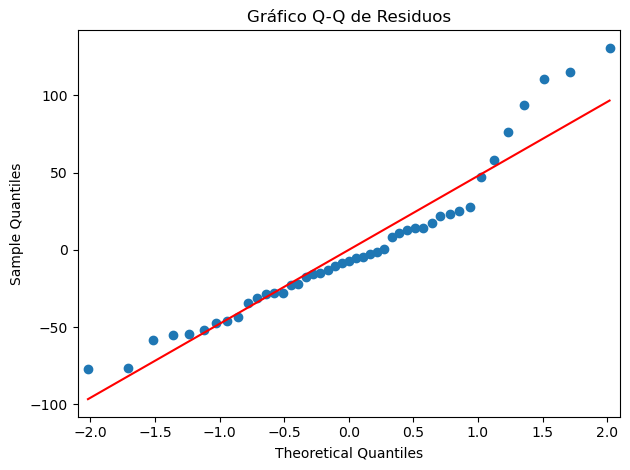

Prueba de Runs: p-valor=0.777165884119708


In [25]:
# Gráficos de residuos
sm.qqplot(modelo.resid, line='s')
plt.title('Gráfico Q-Q de Residuos')
plt.tight_layout()
plt.show()

random_test(modelo.resid)


## Interpretacion:
 Del grafico Q-Q y del valor p de aleatoriedad podemos asegurar que los residuos son suficientemente normales acorde a la grafica mientras que tambien con el valor p de aleatoriedad definimos que son residuos aletorios al rechazar el supuesto H1 con esto podemos definir que su efecto no sera significativo para la ANOVA

## 5. Comparaciones Múltiples 
Test de Tukey para factores significativos.

In [26]:
tukey(df['Resistencia'], df['PVA'], 0.05 , n_factor='PVA')

Prueba Tukey para el factor PVA
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
 10.0%  12.5% -38.6459 0.1891 -91.4305  14.1387  False
 10.0%  15.0%  60.7404 0.0208   7.9559  113.525   True
 12.5%  15.0%  99.3863 0.0001  46.6017 152.1709   True
------------------------------------------------------


## Interpretacion:
 Con la prueba de tukey definimos si se define una diferencia significativa entre los varios niveles de el factor significante (PVA) con lo cual se concluye que los valores 10% y 12.5% no definen una diferencia significativa en la resitencia del material, contrario al valor de 15% el cual demuestra una diferencia sifnificativa al tener un valor p menos a 0.5.

## 6. Conclusión
- El unico factor significativo para la resistencia del material es PVA (p < 0.05).
- La interaccion entre PVA y Ciclo demostro ser significante indicando que al usarlos en conjunto se puede aumentar la resistencia del material pero los ciclos por si solos no tienen un impacto significativo (p > 0.05).
- La resistencia aumenta con mayor concentración de PVA.
- En PVA el unico nivel que llega a tener una diferencia significativa entre los 3 suministrados es 15%, teniendo que entre 10% y 12.5% no se contemplo una diferencia significativa.